In [1]:
import numpy as np

import qcodes as qc
%matplotlib notebook


C:\Users\meso\Anaconda3\envs\qcodes\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from qcodes.instrument_drivers.unibasel.SP927 import SP927

dac = SP927("DAC","ASRL5::INSTR")


Connected to: ? None (serial:None, firmware:None) in 0.13s


In [3]:
import qcodes.instrument_drivers.rohde_schwarz.ZNB as ZNB
vna = ZNB.ZNB('VNA', 'GPIB0::20::INSTR')

c:\git_sync\qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Rohde-Schwarz ZNB8-4Port (serial:1311601044101635, firmware:1.60) in 0.31s


In [7]:
dac.ch1.volt.inter_delay=0.01
dac.ch1.volt.step=0.1

In [8]:
dac.ch1.volt.set(5)

In [9]:
dac.ch1.volt.get()

5.0

# Measuring one trace (linear magnitude and phase)

In [10]:
# set up the VNA
vna.clear_channels()
vna.add_channel('S12')
vna.channels.S12.power(-40)
vna.rf_on()

vna.channels.S12.format('dB') # just for the screen

vna.channels.S12.start(100e3)
vna.channels.S12.stop(6e6)
vna.channels.S12.npts(100)

vna.channels.S12.avg(1)

c:\git_sync\qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


In [11]:
data = qc.Measure(vna.channels.S12.trace_mag_phase).run()

DataSet:
   location = 'data/2018-02-21/#019_{name}_18-08-37'
   <Type>   | <array_id>        | <array.name> | <array.shape>
   Setpoint | frequency_set     | frequency    | (100,)
   Measured | VNA_S12_magnitude | magnitude    | (100,)
   Measured | VNA_S12_phase     | phase        | (100,)
acquired at 2018-02-21 18:08:38


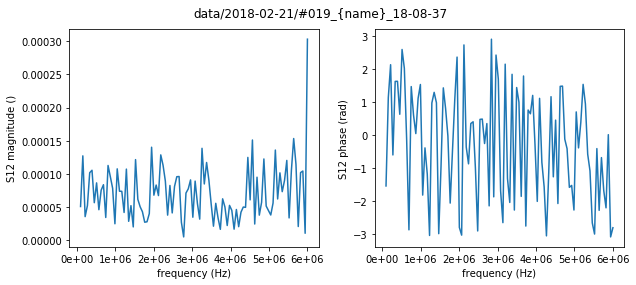

In [16]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

plot = qc.MatPlot(subplots=2)

plot.add(data.VNA_S12_magnitude, subplot=1)
plot.add(data.VNA_S12_phase, subplot=2)

plot.tight_layout()

fig = plot.fig

for subplot in fig.axes:
    subplot.xaxis.set_major_formatter(FormatStrFormatter('%.0e'))


## Conversion from linear to dB scale

In [13]:
# show with log magnitude

log_magnitude = 20*np.log10(np.array(data.VNA_S12_magnitude))

data.add_array(qc.DataArray(preset_data=log_magnitude,name='log_magnitude',  array_id='log_magnitude', label="Magnitude", unit='dB'))


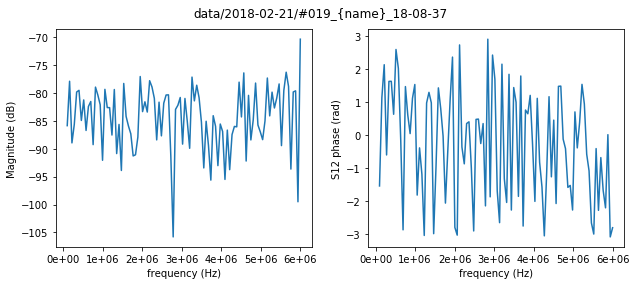

In [14]:
plot = qc.MatPlot(subplots=2)

plot.add(data.frequency_set,data.log_magnitude, subplot=1)
plot.add(data.VNA_S12_phase, subplot=2)

plot.tight_layout()

fig = plot.fig

for subplot in fig.axes:
    subplot.xaxis.set_major_formatter(FormatStrFormatter('%.0e'))

In [15]:
# read-out with scaling
# example: lock-in readout and conversion to conductance in units of 2e^2/h

class conductance_from_lockin(qc.MultiParameter):
    def __init__(self, scale_param):
        # only name, names, and shapes are required
        # this version returns two scalars (shape = `()`)
        super().__init__('conductance_from_lockin', names=('G', 'X'), shapes=((), ()),
                         labels=('Conductance', 'Raw voltage X'),
                         units=('2e^2/h', 'V'),
                         # including these setpoints is unnecessary here, but
                         # if you have a parameter that returns a scalar alongside
                         # an array you can represent the scalar as an empty sequence.
                         setpoints=((), ()),
                         docstring='Conductance converted from raw voltage measurement')
        self._scale_param = scale_param
    
    def get_raw(self):
        voltage = lockin.X.get()
        conductance = voltage * self._scale_param()
        return (conductance, voltage)

bias_voltage = qc.ManualParameter('bias voltage', initial_value=10e-6, units='V')
IVC_gain = qc.ManualParameter('IVC gain', initial_value=1e7)

scaler = 1/(bias_voltage*IVC_gain*75e-6)
conductance = conductance_from_lockin(scale_param=scaler)

my_station = qc.Station(bias_voltage, IVC_gain, lockin, dac)


TypeError: __init__() got an unexpected keyword argument 'units'

In [ ]:
conductance.get()

In [ ]:
loop = qc.Loop(sweep_vals, delay=0.1, station = my_station).each(conductance)
data = loop.get_data_set(name='testsweep')

plot_1d = qc.MatPlot()  # create a plot
plot_1d.add(data.G)  # add a graph to the plot

fig = plot_1d.fig
fig.subplots_adjust(left=0.2, bottom=0.2)

_ = loop.with_bg_task(plot_1d.update).run()  # run the loop

# 2D maps

In [ ]:
dac.ch1.name="gate_voltage"
dac.ch2.name="bias_voltage"

gate_voltage = dac.ch1.volt[0:0.2:0.01]
bias_voltage = dac.ch2.volt[0:0.2:0.01]

loop = qc.Loop(gate_voltage, delay=0.01).loop(bias_voltage,delay=0.01).each(lockin.X)

data = loop.get_data_set(name='testsweep')

plot = qc.MatPlot([*data.lockin_X],data.lockin_X,subplots=3) # create a plot
plot.add(data.lockin_X,subplot=1) # add a graph to the plot
#plot.add([*data.lockin_X],data.lockin_X,subplot=2) # add a graph to the plot
#plot.add([*np.transpose(data.lockin_X)],subplot=3) # add a graph to the plot

#plot.add(bias_voltage, [*data.lockin_X],subplot=1)  # add a graph to the plot

fig = plot.fig
fig.subplots_adjust(left=0.2, bottom=0.2 )

_ = loop.with_bg_task(plot.update).run()  # run the loop